In [40]:
import os
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pickle
import time
import matplotlib.pyplot as plt

**FOR MY COLLEAGUES**<br>
Ignore the part with the dataframes, skip to the last two cells (the one with the class definition and the one after that) and run those. Be sure to have downloaded the file I put on drive and put it in a folder called "files". IMO, this is preferable to changing the path in the cell because if we were to do so we would end up uploading versions with different paths at every git push.

In [2]:
def load_dfs():
    
    if "df_a2q" not in os.listdir("files") \
    or "df_c2q" not in os.listdir("files") \
    or "df_c2a" not in os.listdir("files"):
    
        file_names = ["files/sx-stackoverflow-a2q.txt",
                      "files/sx-stackoverflow-c2q.txt",
                      "files/sx-stackoverflow-c2a.txt"]

        columns = [["user_answering", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_answering", 
                    "time_u"]]

        df_a2q_raw = pd.read_csv(file_names[0],
                                 delim_whitespace=True,
                                 names=columns[0])

        df_c2q_raw = pd.read_csv(file_names[1],
                                 delim_whitespace=True,
                                 names=columns[1])

        df_c2a_raw = pd.read_csv(file_names[2],
                                 delim_whitespace=True,
                                 names=columns[2])

        dfs_raw = [df_a2q_raw, df_c2q_raw, df_c2a_raw]

        print(df_a2q_raw.shape)

        # add a column for a standard visualization of dates
        for df in dfs_raw:
            df["time_h"] = pd.to_datetime(df["time_u"], unit="s")

        names = ["a2q", "c2q", "c2a"]
        for i, df in enumerate(dfs_raw):
            most_recent = df["time_h"].max()
            name = names[i]
            print(f"Most recent date for dataset {name}: {most_recent}")

        threshold = datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0)
        print(f"Date threshold selected: {threshold}")

        df_a2q = df_a2q_raw[df_a2q_raw["time_h"] > threshold].copy()
        df_c2q = df_c2q_raw[df_c2q_raw["time_h"] > threshold].copy()
        df_c2a = df_c2a_raw[df_c2a_raw["time_h"] > threshold].copy()

        dfs = [df_a2q, df_c2q, df_c2a]
        for df in dfs:
            min_el = df["time_u"].min()
            max_el = df["time_u"].max()
            df["weight"] = (df["time_u"] - min_el) / (max_el - min_el)

        with open("files/df_a2q", "wb") as file:
            pickle.dump(df_a2q, file)

        with open("files/df_c2q", "wb") as file:
            pickle.dump(df_c2q, file)

        with open("files/df_c2a", "wb") as file:
            pickle.dump(df_c2a, file)
    
    else:
        
        with open("files/df_a2q", "rb") as file:
            df_a2q = pickle.load(file)
        
        with open("files/df_c2q", "rb") as file:
            df_c2q = pickle.load(file)
            
        with open("files/df_c2a", "rb") as file:
            df_c2a = pickle.load(file)
    
    return df_a2q, df_c2q, df_c2a

In [3]:
names = ["a2q", "c2q", "c2a"]

In [4]:
df_a2q, df_c2q, df_c2a = load_dfs()
print(df_a2q.shape)

(6962095, 5)


In [5]:
df_a2q.head()

,user_answering,user_questioning,time_u,time_h,weight
10861428,95190,960750,1388534405,2014-01-01 00:00:05,0.000000e+00
10861429,607314,2635650,1388534412,2014-01-01 00:00:12,1.018444e-07
10861430,301857,1549201,1388534416,2014-01-01 00:00:16,1.600412e-07
10861431,1419954,1897577,1388534421,2014-01-01 00:00:21,2.327872e-07
10861432,254252,3065375,1388534423,2014-01-01 00:00:23,2.618857e-07


In [6]:
df_c2q.head()

,user_commenting,user_questioning,time_u,time_h,weight
9576868,976391,3061211,1388534408,2014-01-01 00:00:08,0.000000e+00
9576869,445131,2489834,1388534424,2014-01-01 00:00:24,2.327644e-07
9576870,1832636,2721870,1388534427,2014-01-01 00:00:27,2.764078e-07
9576871,822711,3136232,1388534428,2014-01-01 00:00:28,2.909556e-07
9576872,22656,1693074,1388534434,2014-01-01 00:00:34,3.782422e-07


In [7]:
df_c2a.head()

,user_commenting,user_answering,time_u,time_h,weight
14958295,22656,22656,1388534408,2014-01-01 00:00:08,0.000000e+00
14958296,2224701,23385,1388534414,2014-01-01 00:00:14,8.728668e-08
14958297,2732801,2732801,1388534421,2014-01-01 00:00:21,1.891211e-07
14958298,1965449,2325987,1388534422,2014-01-01 00:00:22,2.036689e-07
14958299,26742,26742,1388534423,2014-01-01 00:00:23,2.182167e-07


In [8]:
dfs = [df_a2q,
       df_c2q,
       df_c2a]

In [125]:
def time_wrapper(func):
    """
    Decorator to time functions, probably we won't need it in the final version, but for now I'm leaving it 
    in case you need it too. Just put @time_wrapper above any function you want to time and it will print
    the time in seconds it took to run.
    """
    def wrapped(*args, **kwargs):
        start = time.time()
        r = func(*args, **kwargs)
        print(f"Time elapsed: {time.time()-start}")
        return r
    return wrapped


def visualize_network(graph, edges_to_highlight=[]):
    nx_g = nx.MultiGraph(subg)
    black_edges = [edge for edge in nx_g.edges() if edge not in edges_to_highlight]
    
    plt.figure(figsize=(30, 20))
    pos = nx.spring_layout(nx_g)
    nx.draw_networkx_nodes(nx_g, pos, cmap=plt.get_cmap('jet'), node_size = 500)
    nx.draw_networkx_edges(nx_g, pos, edgelist=edges_to_highlight, edge_color='r', arrows=True)
    nx.draw_networkx_edges(nx_g, pos, edgelist=black_edges, arrows=True)
    plt.show()


class Graph:
    
    def __init__(self):
        self.graph = {}

    
    @time_wrapper
    def create_graph(self, sources, names):
        """
        Args:
            sources: dataframes from which to create the graph
            names: a list of string containing the names of the graph used in order to label the edges accordingly
        
        Summary:
            Each node in the graph acts as a key in the dictionary self.graph. Each entry in the dictionary is itself
            another dictionary, indexed by that node's neighbors and pointing to a list with the details of that edge,
            specifically [type_of_interaction, weight, date_human_format].
            So to make things clearer:
            
            self.graph -> Our entire graph, indexed by node
            self.graph[node "A"] -> dictionary indexed by the neighbors of "A"
            self.graph[node "A"][node "B"] -> details (specifically type of interaction, edge weight and datetime) 
                                                        of the interaction between users "A" and "B" of type a2q.
        """
        
        self.graph = {}
    
        for i_source, source in enumerate(sources):
            nodes_column = source.iloc[:, 0]
            nodes = nodes_column.unique()
            type_of_interaction = names[i_source]
            
            for node in tqdm(nodes):
                if node not in self.graph.keys():
                    self.graph[node] = {}
                node_subdf = source[nodes_column == node]
                neighbors = node_subdf.iloc[:, 1].values
                times_h = node_subdf.iloc[:, 3].values
                weights = node_subdf.iloc[:, 4].values
                for i, neighbor in enumerate(neighbors):
                    if neighbor not in self.graph.keys(): # here we want to make sure that if we're working on a subset
                                                          # of data we still obtain a coherent graph. Otherwise we may
                                                          # end up with neighbors that don't exist as actual nodes
                                                          # in our graph.
                        self.graph[neighbor] = {}
                    if neighbor not in self.graph[node].keys():
                        self.graph[node][neighbor] = []
                    self.graph[node][neighbor].append((type_of_interaction, weights[i], times_h[i]))
                
                
    @time_wrapper
    def save_graph(self, path):
        """
        Args:
            path: name of file where we want the file stored
        Summary:
            Saves graph as a binary file.
        """
        
        with open(path, "wb") as file:
            pickle.dump(self.graph, file)

    
    @time_wrapper
    def load_graph(self, path):
        """
        Args:
            path: name of file to load the graph from.
        Summary:
            Load graph from binary file.
        """
        
        with open(path, "rb") as file:
            self.graph = pickle.load(file)
    
    
    def get_random_subgraph(self, n_nodes=10000):
        np.random.seed(42)
        bad_starting_node = True
        while bad_starting_node:
            random_node = np.random.choice(list(self.graph.keys()))
            if len(self.graph[random_node].keys()) > 5:
                bad_starting_node = False
        print(len(self.graph[random_node].keys()))
        subgraph = {random_node: {}}
        to_check = [random_node]
        i = 0
        
        while len(subgraph.keys()) < n_nodes:
            node = to_check[i]
            if node not in subgraph.keys() or len(subgraph[node].keys()) < 1:
                for neighbor in self.graph[node].keys():
                    if neighbor not in to_check:
                        to_check.append(neighbor)
                    if neighbor not in subgraph.keys():
                        subgraph[neighbor] = {}
                    subgraph[node][neighbor] = self.graph[node][neighbor]
                    if len(subgraph.keys()) >= n_nodes:
                        break
            i += 1
        
        return subgraph
    
    
    @time_wrapper
    def get_neighbors(self, node, interaction="all"):
        """
        Args:
            node: the node we want the neighbors of.
            interaction: the label of the edges we're interested in, default=all, meaning we will obtain all
                         neighbors of that node, regardless of the type of interactions.
        Summary:
            Obtains all the neighbors of a specific node.
        """
        
        if interaction == "all":
            neighbors = list(self.graph[node].keys())
        else:
            neighbors = []
            for neigbhor in self.graph[node].keys():
                if self.graph[node][neighbor][0] == interaction:
                    neighbors.append(neighbor)
        
        return neighbors
        

In [ ]:
# Before running this cell, make sure to have the pickle file in a "files" folder, or change the path of the if 
# condition accordingly. This will take some time: on my pc it takes approximately 7 minutes to load the graph.
# The timing decorator will tell you how much it took, so you can plan accordingly.

g = Graph()

if "merged_graph.p" in os.listdir("files"):
    g.load_graph("files/merged_graph.p")
else:
    g.create_graph(dfs, names=names)
    g.save_graph("files/merged_graph.p")

In [114]:
g = Graph()
g.load_graph("files/merged_graph_lw.p")

Time elapsed: 2.145955801010132


In [120]:
subg = g.get_random_subgraph(100)

1794


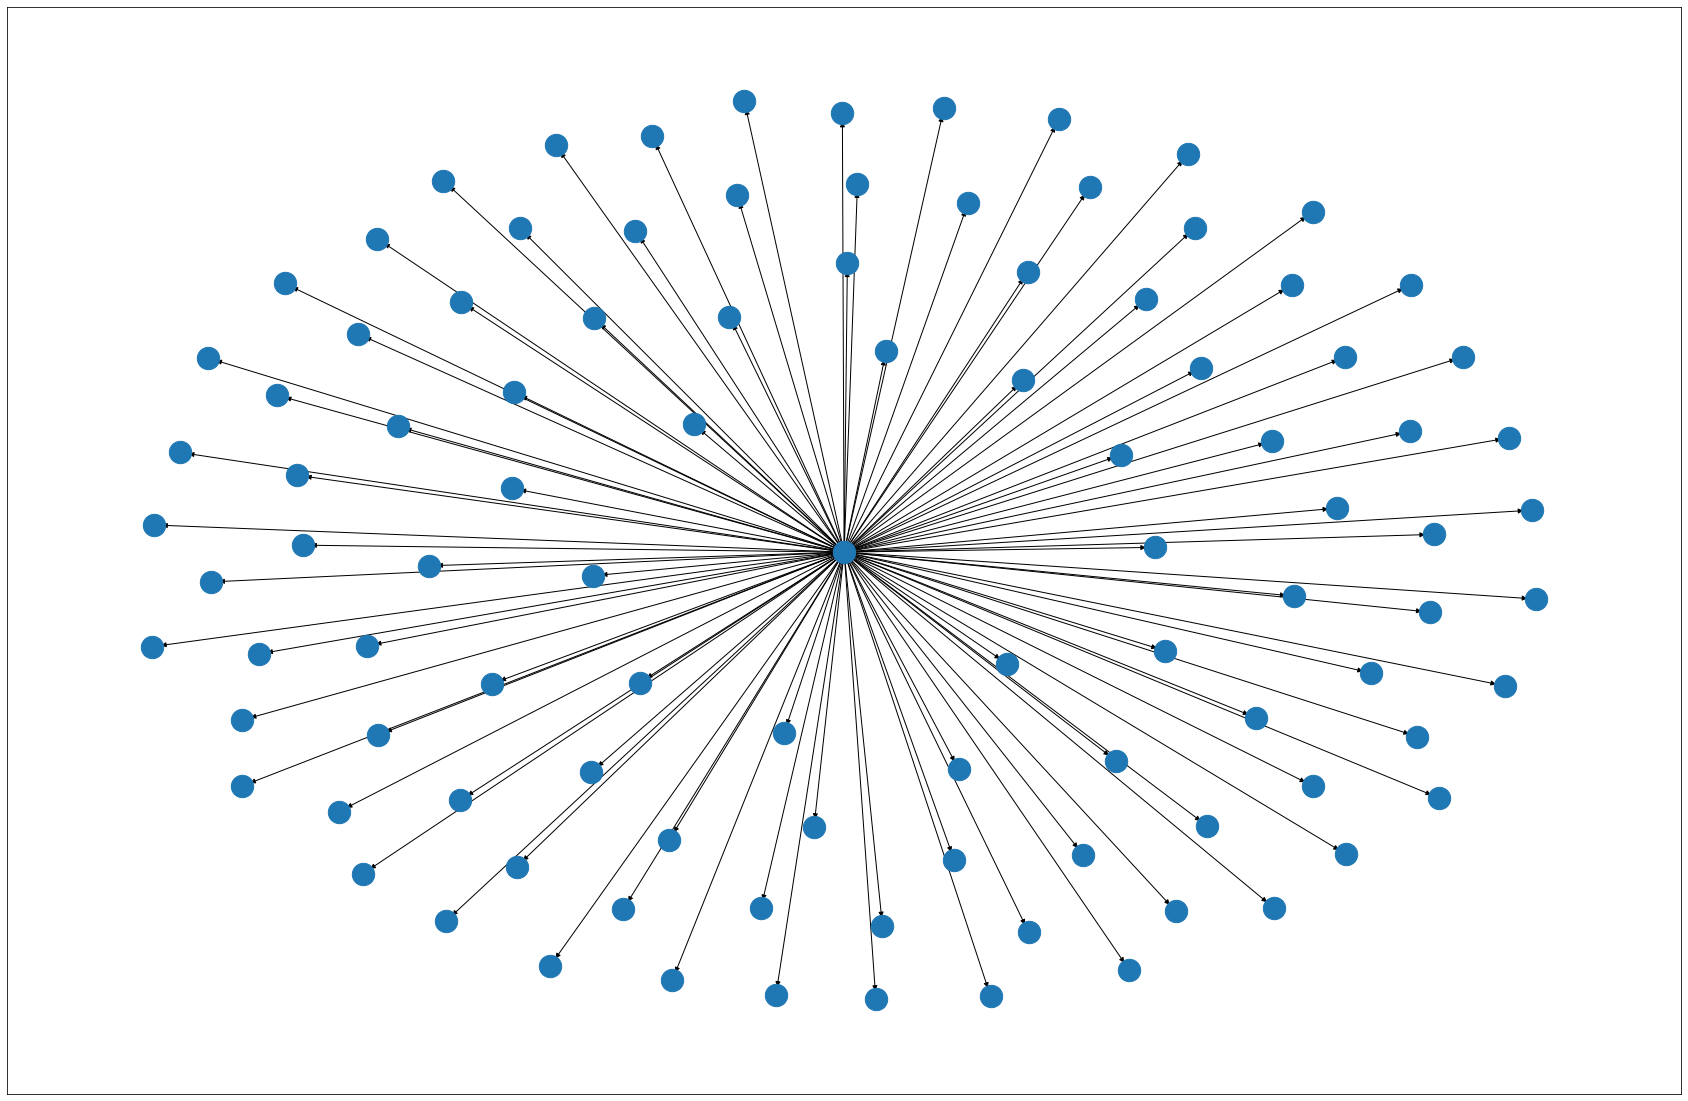

In [127]:
visualize_network(subg)

In [ ]:
def subgraph_for_time_interval(start, end, g, dfs):
    
    start = datetime.strptime(start, "%d %B %Y")
    end = datetime.strptime(end, "%d %B %Y")
    print(f"start: {start}")
    print(f"end: {end}")
    
    for df in dfs:
        sub_df = df[df["time_h"] >= start]
        print(sub_df_1.shape)
        sub_df = df[sub_df_1["time_h"] < end]
        print(sub_df_1.shape)

In [ ]:
start_1 = "10 June 2015"
end_1 = "10 July 2015"
start_2 = "10 December 2014" 
end_2 = "10 January 2015"
subgraph_for_time_interval(start_1 = start_1,
                           end_1 = end_1,
                           start_2 = start_2,
                           end_2 = end_2, 
                           g = g,
                           dfs = dfs)

In [ ]:
df_a2q[df_a2q["time_h"]>x]